# <font color='#069af3'> Plotting & animations</font>

## Introduction

In this notebook, we will:
1. Read in the data we generated in the 2nd notebook
2. Apply some simple statistics on the data
3. Generate some perspective quasi-3D plots
4. Generate geospatial plots, with the number of rainy days being shown in a form of a colourmap and an animated plot, showing the colourmaps for every year studied

## <font color='#069af3'>STEP 0</font>: Importing useful libraries

In [1]:
!pip install contextily
!pip install mplcursors

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 28.3 MB/s eta 0:00:00


In [2]:
# Interactive backend (for interactive plotting)
%matplotlib notebook

# For displaying static plots
%matplotlib inline

# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# For plotting (perspective plots)
from matplotlib.collections import PolyCollection


# For plotting geospatial plots
import geopandas as gpd
from shapely.geometry import Point


# For the animated plot
from matplotlib.animation import FuncAnimation

# For accessing files in Google Drive
from google.colab import drive

# Import Image and display functions
from IPython.display import Image, display

# For interactive map plots
import plotly.express as px
import plotly.graph_objects as go


## <font color='#069af3'>STEP 1</font>: Read the data file in the form of a dataframe

In this step, we will read in the data file we generated in the previous notebook in the form of a pandas dataframe.
The file containes the names of the 270 UK cities and the average rainy days per year from 2001 up to 2023 for these cities.

In [3]:
# Mount contents of Google Drive
drive.mount('/content/drive')

rain_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/rain_AVG_city.txt", sep='\s+')

# Print dataframe to check
print(rain_data)


Mounted at /content/drive
           CITY  2001  2002  2003  2004  2005  2006  2007  2008  2009  ...  \
0        london   139   130    91   130   105   124   111   121   109  ...   
1    birmingham   125   134   103   136   112   129   122   143   131  ...   
2       glasgow   151   193   151   177   155   182   160   185   176  ...   
3     edinburgh   127   170   119   147   131   153   134   168   149  ...   
4     liverpool   173   174   153   198   159   182   172   185   178  ...   
..          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
265   aldershot   133   135    93   128   102   124   118   125   116  ...   
266    abingdon   134   134    95   128   109   124   116   130   123  ...   
267    aberdare   138   170   131   148   137   152   143   165   152  ...   
268   port-erin   143   177   139   171   139   169   144   156   166  ...   
269       laxey   152   171   145   169   151   174   156   164   167  ...   

     2014  2015  2016  2017  2018  20

## <font color='#069af3'>STEP 2</font>: Simple statistics

In this step, we will perform some very simple statistics on the dataset

### 2a: Which UK city was the rainiest in 2021?

In [4]:
# Find idx of max
max_val = np.max(rain_data["2021"])
rain_2021_IDX = np.where( (rain_data["2021"] == max_val) )

Note that here we did not use `np.argmax` to find the index of the maximum, in case there are multiple cities with the same maximum value and `np.agmax` only returns one index

In [5]:
# Find city corresponding to idx
City_rain_2021 = rain_data["CITY"].iloc[rain_2021_IDX]

# Print result
print("The raininest cities in 2021 were:", *City_rain_2021, sep = "\n")

The raininest cities in 2021 were:
ben-nevis


Makes sense that Ben Nevis is the rainiest location, since it's the highest mountain in Scotland, the United Kingdom, and the British Isles (Source: https://en.wikipedia.org/wiki/Ben_Nevis)

### 2b: Which UK city is the rainiest on average (from 2001 up to 2023) ?

In [6]:
# Find AVG rainy days per year for each city
AVG_rain_ALL = [np.average(rain_data.iloc[row, 1:])
                for row in range(len(rain_data))]

# Find max value
max_val_ALL = np.max(AVG_rain_ALL)

# Find max value index
max_idx_ALL = np.where( (AVG_rain_ALL == max_val_ALL) )

# Find name of the rainiest city
Rainiest_city = rain_data["CITY"].iloc[max_idx_ALL]

# Print result
print("The raininest cities since 2000 are:", *Rainiest_city, sep = "\n")



The raininest cities since 2000 are:
ben-nevis


### 2c: How many days does it rain in the UK on average?

In [7]:
# Find AVG over all cities
AVG_rain = int(np.average(AVG_rain_ALL))

# Print result
print("On average in the UK, it rains", AVG_rain, "days per year")

On average in the UK, it rains 139 days per year


## <font color='#069af3'>STEP 3</font>: Generating glass-like perspective plots

Now, we will plot the data set in the form of perspective plots

First, we will need to format our data in order to generate polygons for our plot:
* **X array**: Repeat the "years" column for each city
* **Y array**: Data array contianing rainy days per year for each city and each year
(same as the rain_data dataframe, without the city names)
BUT shifted upwards, so that the y-axis starts from 0. Otherwise, the plot would be misaligned w.r.t. to the 3D wire frame

* **Z array**: The index of each city, to space out data for better visualisation

In [8]:
# Get array with years (from txt file)
years = np.loadtxt("/content/drive/My Drive/Colab Notebooks/rain_AVG_city.txt", usecols = range(1, 24), max_rows = 1)

#  X = YEAR
x = np.repeat(years[np.newaxis], len(rain_data["CITY"].iloc[1:]), axis = 0).T

print("X =", x)

# Y = AVG rainy days
y = np.array(rain_data.iloc[:, 1:]).T

print("Y =", y)

y_new = [ y[:,i] - np.min(y[:,i])
                 for i in range(len(rain_data)) ]

# Convert to 2D arr (from list of arr)
y_new = np.stack(y_new, axis = 1)

# Z = idx for each CITY
z = np.arange(0, len(rain_data["CITY"].iloc[1:]))

X = [[2001. 2001. 2001. ... 2001. 2001. 2001.]
 [2002. 2002. 2002. ... 2002. 2002. 2002.]
 [2003. 2003. 2003. ... 2003. 2003. 2003.]
 ...
 [2021. 2021. 2021. ... 2021. 2021. 2021.]
 [2022. 2022. 2022. ... 2022. 2022. 2022.]
 [2023. 2023. 2023. ... 2023. 2023. 2023.]]
Y = [[139 125 151 ... 138 143 152]
 [130 134 193 ... 170 177 171]
 [ 91 103 151 ... 131 139 145]
 ...
 [130 140 171 ... 181 154 158]
 [119 137 197 ... 193 177 175]
 [135 165 187 ... 217 188 185]]


Define vertices of polygons for each city (z values) in tuple form (xs, ys) ---> (year, rainy_days)
<br>
The first and last elements of the vertices array have x = 0 so that polygons start and end at the x-axis

In [9]:
# Generate vertices array
verts = []
for zi in range(len(z)):

    xs = np.concatenate([[x[0,zi]], x[:,zi], [x[-1,zi]]])
    ys = np.concatenate([[0], y_new[:,zi], [0]])

    # Vertices (of polygons): (X = Year; Y = Rainy days)
    verts.append(list(zip(xs, ys)))


# Set colourmap
facecolors = plt.colormaps['plasma'](np.linspace(0, 1, len(verts)))

# Plot vertices as polygons
poly = PolyCollection(verts, facecolors = facecolors)

# Set transparency to 0.5
poly.set_alpha(0.5)

Now, plot polygons and format axes

Text(0.5, 0, 'Rainy days')

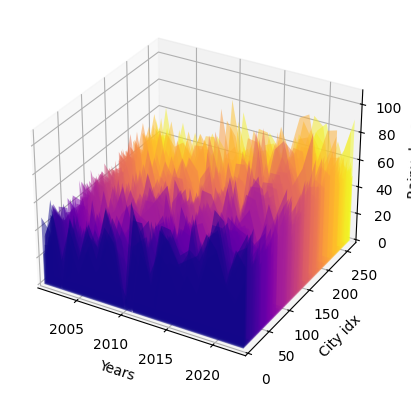

In [10]:
# Initialise plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot and flip x and z axis (so that z shows the different cities)
ax.add_collection3d(poly, zs = z, zdir='y')

# Set axis limits & labels

# X
ax.set_xlim3d(x.min(), x.max())
ax.set_xlabel('Years')

# Y
ax.set_ylim3d(z.min(), z.max())
ax.set_ylabel('City idx')

# Z
ax.set_zlim3d(y_new.min(), y_new.max())
ax.set_zlabel('Rainy days')

The problem with this plot is that it becomes very cumbersome for a large amount of data. Therefore, if we want to compare the trends in the rainy days between the different cities, we should study only a few of them at a time.
<br>
Now, we will isolate the data for the first 5 cities and plot the perspective-type of plot, while also changing the position of the camera and formatting the axes to make the visualisation as clear as possible.

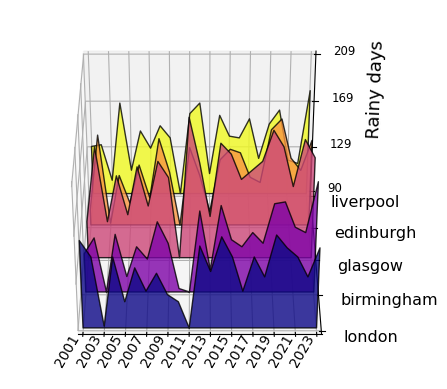

In [11]:
# Isolate the 5 first cities
x_5 = x[:,:5]
y_5 = y_new[:,:5]
z_5 = np.arange(0, 500, 100) # spaced out by 10 units


# Array containing the vertices of the polygons
verts_5 = []
for zi in range(len(z_5)):

    xs_5 = np.concatenate([[x_5[0,zi]], x_5[:,zi], [x_5[-1,zi]]])
    ys_5 = np.concatenate([[0], y_5[:,zi], [0]])

    # Append to list
    verts_5.append(list(zip(xs_5, ys_5)))



# Viridis colourmap
facecolors_5 = plt.colormaps['plasma'](np.linspace(0, 1, len(verts_5)))

# Add facecolour from cmap; black contour
poly_5 = PolyCollection(verts_5, facecolors = facecolors_5, edgecolors = "Black")

# Make plot semi-transparent
poly_5.set_alpha(0.8)



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# re-orient axes: show "rainy days" on y-axis
ax.add_collection3d(poly_5, zs = z_5, zdir='y')


# Adjust camera positions
ax.azim = 270  # rotate around z-axis => Front view
ax.elev = 35  # elevation => look from above
ax.dist = 20  # zoom




# Set axis limits & labels & positions


## X - axis ##

# Adjust gap between axis; tick label; font size
ax.tick_params(axis='x', pad = 7, labelsize = 10)

# Adjust ticks; labels; position of labels
ax.set_xticks(ticks = np.arange(int(years[0]), int(years[-1] + 2), 2),
              labels = np.arange(int(years[0]), int(years[-1] + 2), 2),
              rotation = 60, va='baseline', ha='right')

# Set axis limits
ax.set_xlim3d(x_5.min(), x_5.max())



## Y - axis ##

# Adjust gap between axis; tick label; font size
ax.tick_params(axis='y', pad = 5, labelsize = 11.5)

# Adjust ticks; labels = CITY names; position of labels
ax.set_yticks(ticks = z_5, labels = rain_data["CITY"].iloc[0:5],
              rotation = 0, va='bottom', ha='left')

# Set axis limits
ax.set_ylim3d(z_5.min(), z_5.max())




## Z - axis ##

# Adjust gap between axis; tick label; font size
ax.tick_params(axis='z', pad = 3, labelsize = 8.5)


# Set ticks (shifted data); labels (original data)
ax.set_zticks(ticks = np.linspace(y_5.min(), y_5.max(), num = 4),
              labels = np.linspace(y[:,:5].min(), y[:,:5].max(),
                                   num = 4).astype(int),
              rotation = 0, va='top', ha='left')


ax.set_zlabel('Rainy days', labelpad = 20, fontsize = 13)

# Set axis limits (shifted vals)
ax.set_zlim3d(y_5.min(), y_5.max())


# Zoom in by adjusting distance between plot & camera
ax.dist = 8

Note that the values on the y-axis (rainy days) had been shifted so they would start at y = 0.
<br>
However, the labels on the axis correspond to the values of the original, un-shifted data. This was achieved by
setting the ticks based on the shifted data and writing the labels based on the original values.

#### <font color='#069af3'>Conclusion?</font>

* The benefit of this type of plots is that thanks to the perspective and the transparency, we can look at multiple 2D plots at the same time and compare them, drawing qualitative results.
<br>
<br>
* We can tell that the overall rain patterns are similar between the 5 cities, with some exceptions. For example, in 2011 even though it rained the least in  **<font color='#0c0786'>London</font>** and **<font color='#7e03a7'>Birmigham</font>**, it rained the most in **<font color='#cb4777'>Glasgow</font>**, **<font color='#f89540'>Edinburgh</font>** and **<font color='#eff821'>Liverpool</font>**.

## <font color='#069af3'>STEP 4</font>: Geospatial colourmaps
Since our data refers to different cities in the UK, we can plot their location
on the map. Then, we can compare respective rainy days with the use of a colourmap. Finally, we will make an interactive plot, showing the geospatial colour maps for each year from 2001 to 2023.

A common way of dealing with geospatial data is to first save it into a ``geopandas``dataframe format and then plot it on a map.
<br>
_Source: https://geopandas.org/en/stable/getting_started/introduction.html_

A geopandas dataframe is simply a dataframe, with an added "geometry" column, which contains the geographical coordinates associated with each element, as illustrated in the following image. In our case, "geometry" contains the coordinates of each city, after they have been converted from the (Longitude, Latitude) format into spatial points.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


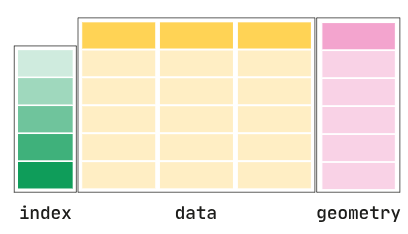

In [12]:
# Upload image from Google Drive
drive.mount('/content/drive')

# Path
img_path = '/content/drive/My Drive/Colab Notebooks/geodf.png'

# Display image
display(Image(filename=img_path))

For our ``geopandas`` dataframe, we want to add the city coordinates, which we already have from the previous notebook (Automation) to the rain_data dataframe.

In [13]:
# Read in coordinates for each city from file
coords_cities = pd.read_csv("/content/drive/My Drive/Colab Notebooks/City_coords.txt", sep='\s+')


# Zip coordinates into a single column
coords_cities['coords'] = list(zip(coords_cities.Longitude,
                                   coords_cities.Latitude))


After reading in the city coordinates, we noticed that the order of the cities is different between the two dataframes, as shown below for the first 5 of them:




In [14]:
# Print first 5 city names (coordinates)
print("City coordinates:" + '\n')
print(coords_cities["Link"].head(5))
print('\n'+ '\n')

# Print first 5 city names (rain data)
print("Rain data:" + '\n')
print(rain_data["CITY"].head(5))

City coordinates:

0           london
1       birmingham
2        edinburgh
3        liverpool
4    great-britain
Name: Link, dtype: object



Rain data:

0        london
1    birmingham
2       glasgow
3     edinburgh
4     liverpool
Name: CITY, dtype: object


We scraped the city coordinates from GeoNames twice, with a month between these two times. The first one was to provide us with the Latitude and Longitude in order to request the rain data for the 270 UK cities from the API ("rain_AVG_city.txt"). The second time was to write the coordinates into a text file ("City_coords.txt"), in order to retrieve them later.

So, we suspected that the mis-matching happened because the order of the cities in the database might have been updated in the meantime between the two calls of GeoNames.

We can combine the two dataframes in a way that ensures that the coordinates and the weather data point to the same city, using the ``merge`` function:

In [15]:
# Merge "rain_data" and "coords_cities" into one df, which matches the cities
combined_df = pd.merge(rain_data, coords_cities,
                       how='inner', left_on="CITY", right_on="Link")

# Print 5 first cities to check
print("City column" + '\n')
print(combined_df["CITY"].head(5))
print("Link column" + '\n')
print(combined_df["Link"].head(5))


# Drop unecessary columns
combined_df.drop(columns = ["Link", "Latitude", "Longitude"], inplace=True)


# Convert into geodataframe (use last column as "geometry")
comb_df_GEO = gpd.GeoDataFrame(combined_df, crs = "epsg:4326",
                          geometry = combined_df['coords'].apply(Point))

# Drop "coords" column (not to confuse with "geometry")
comb_df_GEO.drop(columns = ["coords"], inplace=True)


City column

0        london
1        london
2    birmingham
3       glasgow
4     edinburgh
Name: CITY, dtype: object
Link column

0        london
1        london
2    birmingham
3       glasgow
4     edinburgh
Name: Link, dtype: object


Now, we have created our geopandas dataframe, with the geometry column in the form of "points". We will then need to convert the points to the coordinate reference system (CRS), which tells Python how those coordinates relate to places on the Earth:



In [19]:
# Change coordinate system to match with webtiles (4326)
comb_df_GEO = comb_df_GEO.to_crs(epsg = 4326)

# Print CRS info
comb_df_GEO.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Here, we have used the commonly used CRS World Geodetic System 1984, which expresses locations on the Earth's surface, using the latitude and logitude, by passing the argument ``crs = epsg:4326``
<br>
_Source: https://geopandas.org/en/stable/docs/user_guide/projections.html_

### 4a: Colourmap for one year (2001)


We now seek plot our geopandas dataframe for the first year (2001). But, we also want to add a background map of the UK in the same figure, so that we can visualise the exact location of each city. The background map is added through the use of web map tiles from freely available maps (here, we used openstreetmap).

Even though there are many libraries that can do this (e.g. the ``contextily`` package), only ``plotly`` is supported by Google Colab.
Here, we have used the Scattermapbox package, in a similar way to the third example from the plotly documentation: _https://plotly.com/python/tile-scatter-maps/_.

The plot is generated in 3 steps:
- **Step 1**: Create a scatter plot, with each point representing one of the 270 UK cities on the map. The relative number of rainy days is represented by a colour map, with the least rainy cities showing in blue and the rainiest ones in yellow. Also, the name of each city appears when hovering over it with the mouse.

- **Step 2**:
- Step 3:

In [17]:
# STEP 1: Create colourmap of rain data for 2001 with hovering labels of city names
fig = go.Figure(go.Scattermapbox(
    lon = comb_df_GEO["geometry"].x,   # Longitude
    lat = comb_df_GEO["geometry"].y,   # Latitude
    mode = 'markers',
    marker = dict(size = 8, color = comb_df_GEO['2001'], colorscale = 'Viridis', # Use the '2001' column for coloring
                  colorbar = dict(title = 'Rainy days count')), # Add colour bar
    text = comb_df_GEO['CITY'],  # show city names ONLY when hovering
    hovertemplate = "%{text}<extra></extra>"  # remove Lat/Long from hovering labels
))



# STEP 2: Add the basemap, centered around the UK, using OpenStreetMap web tiles
fig.update_layout(
    mapbox=dict(
        style = "open-street-map",  #  tiles
        zoom = 5,  # Adjust zoom level
        center = dict(lon=0, lat=54)  # Center the map over the UK
    ),
    margin = {"r":0,"t":0,"l":0,"b":0}  # Remove margins around the plot
)


# STEP 3: Set axis limits for a more readable plot)
fig.update_layout(
    xaxis=dict(range=[-6e6, 2e6], visible = False),
    yaxis=dict(range=[5e6, 6e6], visible = False)
)

# Show figure
fig.show()


#### <font color='#069af3'>Conclusion?</font>

* The geospatial colourmap is a better way of visualising the distribution of the rainy days within the UK, compared to the perspective plots. This is because it enables us to compare the amount of rainy days per year between all of the 270 cities studied.
<br>
<br>
* For 2001, we can see that the rainiest location was the Ben Navis mountain in Scotland, which is the only yellow point. The next rainiest places (shown in green) were also located in Scotland (Ayr, Greenock). Similar number of rainy days were seen in the northwest of England (Liverpool, Blackpool, Southport), while the West Midlands and the south were the least rainy.



### 4b: Animated geospatial colourmaps

Now, if we want to compare rain patterns over the years, we can plot a map for each year and generate an animation.
<br>
<br>
We can do this by using the ``FuncAnimation`` package of the ``matplotlib.animation`` library.
<br>
<br>
First, we need to write a function that plots the colourmap and adds the basemap in the same figure (ax). This function takes as inputs the "frame" variable, which acts as an iterator (i) and the "ax" argument, which is the subfigure generated at each iteration.
<br>
<br>
_**Note**_: _The minimum and maximum values of the rain data change every year. So, the colourmap is adjusted accordingly for every iteration, and so the colourbar should be updated as well. However, after numerous tries, I have been unsccessful in plotting a new colourbar at every iteration._

Now that we have the plotting function ready, we can pass it to ``FuncAnimation``, which automatically iterates through every frame and generates a new plot each time. "Frame" ranges from 0 to 22, since we passed the argument ``frames = np.arange(0, len(years))``, with one frame representing one year, from 2001 to 2023.
<br>
After generating the animated plot, we have to save it. Otherwise, the animation object will be garbage collected and we will not be able to visualise the animation.
<br>
_**Source: https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html#matplotlib.animation.FuncAnimation**_

In [18]:
# Create one frame (ie plot) for each year (contains all cities) in the same way as previous plot


frames = []
for i in range(len(years)):

    # Convert each year to string (df column name)
    yr = str(int(years[i]))

    fig = go.Figure(go.Scattermapbox(
    lon = comb_df_GEO["geometry"].x,   # Longitude
    lat = comb_df_GEO["geometry"].y,   # Latitude
    mode = 'markers',
    marker = dict(size = 8, color = comb_df_GEO[yr], colorscale = 'Viridis', # Use the '2001' column for coloring
                  colorbar = dict(title = 'Rainy days count')), # Add colour bar
    text = comb_df_GEO['CITY'],  # show city names ONLY when hovering
    hovertemplate = "%{text}<extra></extra>",  # remove Lat/Long from hovering labels
    uid = yr
    ))

    # Update the layout for the basemap => add OpenStreetMap web tiles
    fig.update_layout(
        mapbox=dict(
            style = "open-street-map",  #  tiles
            zoom = 5,  # Adjust zoom level
            center = dict(lon=0, lat=54)),  # Center the map over the UK
        margin = {"r":0,"t":0,"l":0,"b":0})  # Remove margins around the plot


    # Set (x,y) limits (excludes island of South Georgia; more readable plot)
    fig.update_layout(
        xaxis=dict(range=[-6e6, 2e6], visible = False),
        yaxis=dict(range=[4e6, 6.5e6], visible = False))   ## UPDATE


    # Set up slider: show a plot for one year at a time
    frames += [go.Frame(data = fig.data[0], layout = fig.layout, name = yr)]

    # Store the first frame to reuse later ### NEEDED??
    if i == 0:
        first_fig = fig

fig = go.Figure(frames=frames)



# Add the first frame to the figure so it shows up initially
fig.add_trace(first_fig.data[0],)
fig.layout = first_fig.layout


## the rest is coped from the plotly documentation example on mri volume slices
def frame_args(duration):
    return {
            "frame": {"duration": duration},
            "mode": "immediate",
            "fromcurrent": True,
            "transition": {"duration": duration, "easing": "linear"},
        }

sliders = [
            {
                "pad": {"b": 10, "t": 60},
                "len": 0.9,
                "x": 0.1,
                "y": 0,
                "steps": [
                    {
                        "args": [[f.name], frame_args(0)],
                        "label": str(k),
                        "method": "animate",
                    }
                    for k, f in enumerate(fig.frames)
                ],
            }
        ]

fig.update_layout(
         title='Slices in volumetric data',
         width=1200,
         height=600,
         scene=dict(
                    zaxis=dict(range=[-0.1, 6.8], autorange=False),
                    aspectratio=dict(x=1, y=1, z=1),
                    ),
         updatemenus = [
            {
                "buttons": [
                    {
                        "args": [None, frame_args(1000)],  # nbr controls how slow the frames change
                        "label": "&#9654;", # play symbol
                        "method": "animate",
                    },
                    {
                        "args": [[None], frame_args(0)],
                        "label": "&#9724;", # pause symbol
                        "method": "animate",
                    },
                ],
                "direction": "left",
                "pad": {"r": 10, "t": 70},
                "type": "buttons",
                "x": 0.1,
                "y": 0,
            }
         ],
         sliders=sliders
)



# Show figure
fig.show()
